## Assignment 2

Name        : Chia Sin Liew   
Last edited : March 31st, 2022 

The goal of this assignment is to solve regression and classification problems using following models.

- **Part A**: Regression Problem – Linear Regression using the Stochastic Gradient Descent algorithm
- **Part B**: Classification Problem – K-Nearest Neighbors

## Part B: Classification Problem – K-Nearest Neighbors

You will perform binary classification on a COVID-19 misinformation dataset. Your goal is to obtain high precision and recall for the misinformation class. You will use the K- Nearest Neighbors (K-NN) model (use Scikit-Learn implementation).

### **Dataset**:
CoAID (Covid-19 heAlthcare mIsinformation Dataset) is a diverse COVID-19 healthcare misinformation dataset, including fake news on websites and social platforms, along with users’ social engagement about such news. https://github.com/cuilimeng/CoAID

For this task, you will use the fake and true news articles that are collected from the fact- checked or reliable websites. The true/real and fake news articles are stored in two CSV files: NewsRealCOVID-19-05.csv & NewsFakeCOVID-19-05.csv

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from collections import defaultdict
from scipy import stats

[nltk_data] Downloading package wordnet to /Users/chiasin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chiasin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/chiasin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### **Pre-Processing**:
Following pre-processing steps need to be done:
- Load the two CSV files as two Pandas DataFrame objects.


In [2]:
df_real = pd.read_csv("Dataset-Assignment2/NewsRealCOVID-19-05.csv")
df_fake = pd.read_csv("Dataset-Assignment2/NewsFakeCOVID-19-05.csv")

- Create label columns for each DataFrame object. Use value 1 for true/real news dataset and 0 for fake news dataset.

In [3]:
df_real['label'] = 1
df_fake['label'] = 0

- Concatenate the two DataFrame objects vertically.

In [4]:
df_all = pd.concat([df_real, df_fake], ignore_index=True)

- Extract only two columns for this task.

In [5]:
df = df_all.loc[:, ['content', 'label']]

- **Exploratory Data Analysis (EDA)**: Perform EDA as shown in the following notebook: https://github.com/rhasanbd/Text-Analytics-Beginners-Toolbox/blob/master/Text%20Analytics-III-Classification.ipynb

Report: include the observations from EDA.


##### Quick check of data

In [6]:
print(df.head(10))
print(df.tail(10))

                                             content  label
0  experts warn most states that are reopening st...      1
1  a new study finds an increase in screen time d...      1
2  scientists around the world are working on a n...      1
3  coronaviruses cause respiratory illnesses so t...      1
4  medical experts are studying if remdesivir can...      1
5  your social media posts may say more about you...      1
6  experts say rural areas have older populations...      1
7  an early study indicated an antimalarial drug ...      1
8  experts say that while some studies have shown...      1
9  for people who were hospitalized with covid-19...      1
                                                content  label
2152                                                NaN      0
2153                                                NaN      0
2154                                                NaN      0
2155  elisa granato the first volunteer who availed ...      0
2156  the president thank

##### Get information on the Pandas DataFrame Object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1522 non-null   object
 1   label    2162 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.9+ KB


##### Check for null values in columns

In [8]:
df.isna().values.any()

True

##### Remove rows containing NaN in the "content" column

In [9]:
df = df[df.content.notna()]
# print(df.head(10))
# print(df.tail(10))

##### Dimension of the Data

In [10]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d " % no_of_rows)
print("No. of Columns: %d " % no_of_columns)

Dimension of the data:  (1522, 2)

No. of Rows: 1522 
No. of Columns: 2 


##### Class Distribution

In [11]:
df.groupby('label').count()

,content
label,
0,125
1,1397


##### Visualization of the Class Distribution

/opt/homebrew/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

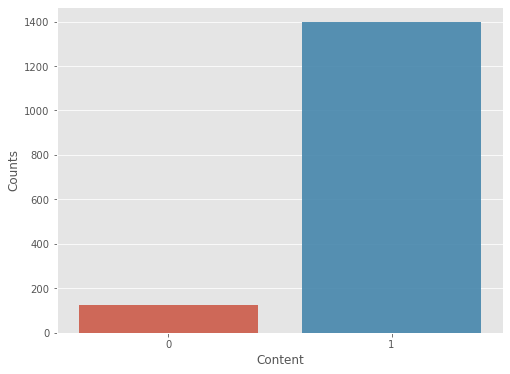

In [12]:
label_counts = df.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xlabel('Content', fontsize=12)
plt.ylabel('Counts', fontsize=12)

##### Correlation between the News article length & the Class (Real/Fake)

In [13]:
# Create a new column "length" that stores the length of the text on each row
df['length'] = df['content'].map(lambda content: len(content))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,125.0,441.048000,124.378251,36.0,488.0,492.0,494.0,500.0
1,1397.0,473.110236,73.065309,64.0,489.0,492.0,495.0,502.0


##### Visualize length distribution by Class

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

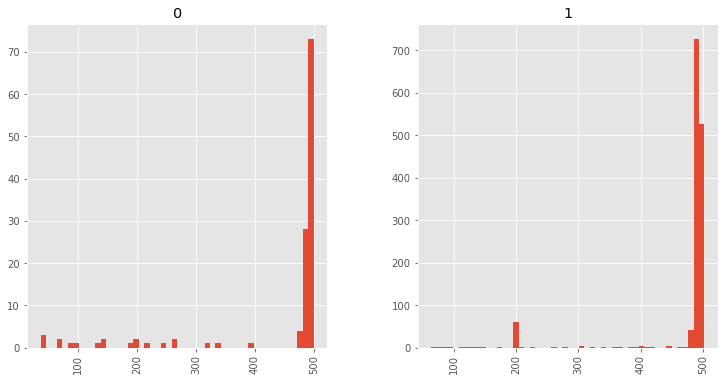

In [14]:
# all articles
df.hist(column = 'length', by = 'label', bins = 50, figsize = (12, 6))

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

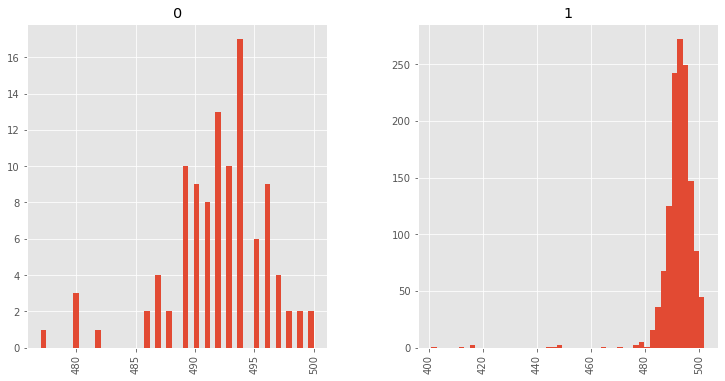

In [15]:
# Use a length threshold to visualize the distribution of length per class
# only visualize news articles longer than threshold

threshold = 400
news_subset = df[df.length > threshold]
news_subset.hist(column = 'length', by = 'label', bins = 50, figsize = (12,6))

In [16]:
print(label_counts)
fake_percent = label_counts[0]/(label_counts[0]+label_counts[1])*100
print("\nProportion of news articles that are fake: %.2f%s " % (fake_percent, "%"))

1    1397
0     125
Name: label, dtype: int64

Proportion of news articles that are fake: 8.21% 


##### Observation fro the EDA

We observe that **only 8.21%** news articles are fake.

Long news articles (>480) are observed more frequently in real articles.

#### Feature Extraction

- Use the same training and test subsets from all experiments.
- Perform text normalization by using the lemmatization technique.

##### Text Normalization by Lemmatization

In [17]:
%%time

lemmatizer = WordNetLemmatizer()

df['content_lemmatized'] = df['content'].map(lambda content: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(content.lower())))

CPU times: user 2.75 s, sys: 70.7 ms, total: 2.82 s
Wall time: 2.84 s


##### Observe a Random Article before & after Normalization

In [18]:
print("\nArticle (no lemmatization): \n")
print(df['content'][44])
print("\nLemmatized Article: \n")
print(df['content_lemmatized'][44])


Article (no lemmatization): 

experts say rural areas have older populations that are less healthy and have fewer medical facilities than urban and suburban regions. jeremy hogan echoes wire barcroft media via getty images the covid-19 pandemic has already swept through cities and urban centers. now the illness appears to be building like an infectious prairie fire in rural america as well as in larger towns in the midwest. that was nt the case just a month ago. many rural communities are nt seeing anything. they re sim. 

Lemmatized Article: 

expert say rural area have older population that are le healthy and have fewer medical facility than urban and suburban region . jeremy hogan echo wire barcroft medium via getty image the covid-19 pandemic ha already swept through city and urban center . now the illness appears to be building like an infectious prairie fire in rural america a well a in larger town in the midwest . that wa nt the case just a month ago . many rural community are 

###### Wordcloud of real articles

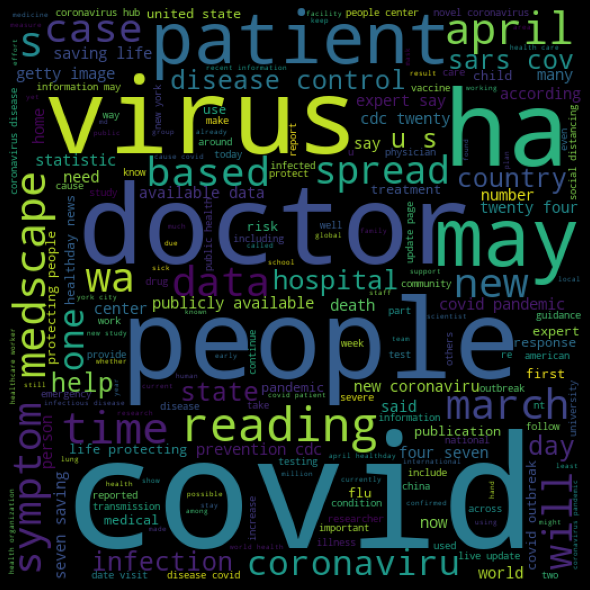

In [19]:
real_words = ''.join(list(df[df.label == 1]['content_lemmatized']))
real_wordcloud = WordCloud(width = 512, height = 512).generate(real_words)

plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(real_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

###### Wordcloud of fake articles

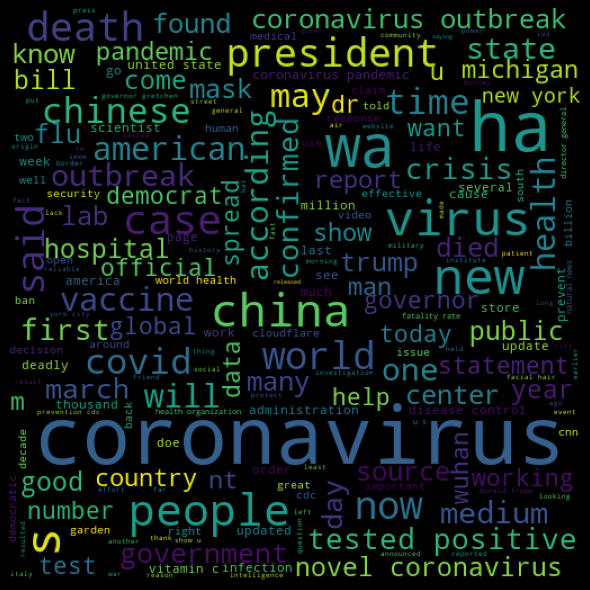

In [20]:
fake_words = ''.join(list(df[df.label == 0]['content_lemmatized']))
fake_wordcloud = WordCloud(width = 512, height = 512).generate(fake_words)

plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(fake_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

- Create a separate feature set (Data Matrix X) and target (1D Array y).

In [21]:
def create_feature_target_arrays(df, target, drop_columns):
    '''
       Create target and feature numpy arrays that
       are ready for train_test_split,
       returns a tuple of feature, X (data matrix) 
       and target, y (1D array)
    '''
    # y for target
    y = df[target]
    # X for features
    X = df.drop(columns=drop_columns)

    print("\nData frame for features(X): \n", X.head())
    print("\nDimension of X: ", X.shape)
    print("\nData frame for target(Y): \n", y)
    print("\nDimension of Y: ", y.shape)

    # convert into np arrays
    X = np.asarray(X).ravel()
    y = np.asarray(y).ravel()

    print("\nX data type: ", X.dtype)
    print("Y data type: ", y.dtype)
    
    return(X, y)


X, y = create_feature_target_arrays(df, 'label', ['label', 'length', 'content'])

# Read a random "article" from X
print("\nA random article: \n")
print(X[0])


Data frame for features(X): 
                                   content_lemmatized
0  expert warn most state that are reopening stil...
1  a new study find an increase in screen time do...
2  scientist around the world are working on a nu...
3  coronaviruses cause respiratory illness so the...
4  medical expert are studying if remdesivir can ...

Dimension of X:  (1522, 1)

Data frame for target(Y): 
 0       1
1       1
2       1
3       1
4       1
       ..
2143    0
2146    0
2149    0
2155    0
2156    0
Name: label, Length: 1522, dtype: int64

Dimension of Y:  (1522,)

X data type:  object
Y data type:  int64

A random article: 

expert warn most state that are reopening still are nt doing enough testing a more u.s. state start to loosen stay at home order expert warn that covid-19 could come back if there s not enough testing . according to the associated press a significant number of state that are reopening are still not meeting key testing benchmark suggested by harvard glob

- Partition the data in training & test subsets (80% - 20%).

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1217,)
(305,)
(1217,)
(305,)


Before using the K-NN model, you need to vectorize the text features. See how this can be done from the following notebook: https://github.com/rhasanbd/Text-Analytics-Beginners-Toolbox/blob/master/Text%20Analytics-III-Classification.ipynb

Note that the feature vectorization can be done in multiple ways: using binary features, using frequency of the features, and using the TF-IDF values of the frequency counts. You will have to determine the optimal vectorization technique by comparing 3 techniques.

Finally, the K-NN vectorized data matrices (train & test) need to be standardized before performing model selection.

### **Experiments**:

Report the following results for each experiment:
- Test accuracy
- Test Confusion Matrix
- Test Classification Report

#### Steps from Vectorization to Model Evaluation
1. Vectorize with one of the three methods (binary features, frequency of the features & the TF-IDF values).
2. Standardize/Scale the features.
3. Model selection by hyperparameter tuning.
4. Train the model.
5. Evaluate the model on test data.

##### 1. Content Preprocessing & Feature Vectorization

In [23]:
%%time

# TF-IDF values
tfidf_vect = TfidfVectorizer(stop_words='english')

# Create a matrix representation of the training data
X_train_tfidf_vectorized_features = tfidf_vect.fit_transform(X_train).todense()

print("\nCount vectorized training data matrix (TF-IDF) dimension: ", X_train_tfidf_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(tfidf_vect.vocabulary_))

# ... and now for the test data
X_test_tfidf_vectorized_features = tfidf_vect.transform(X_test).todense()

print("Count vectorized testing data matrix (TF-IDF) dimension: ", X_test_tfidf_vectorized_features.shape)

# Convert the feature matrices into numpy ndarrays
X_train_tfidf_vectorized_features = np.asarray(X_train_tfidf_vectorized_features)
X_test_tfidf_vectorized_features = np.asarray(X_test_tfidf_vectorized_features)


Count vectorized training data matrix (TF-IDF) dimension:  (1217, 7219)

Size of Vocabulary:  7219
Count vectorized testing data matrix (TF-IDF) dimension:  (305, 7219)
CPU times: user 286 ms, sys: 44.4 ms, total: 330 ms
Wall time: 154 ms


###### 2. Standardize/Scale the features

In [24]:
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train_tfidf_vectorized_features)

# Apply transformation to both the training and test sets
X_train_tfidf_vectorized_features = scaler.transform(X_train_tfidf_vectorized_features)
X_test_tfidf_vectorized_features = scaler.transform(X_test_tfidf_vectorized_features)

#### **Experiment 2:** 
Perform binary classification using the K-NN. Use hyperparameter tuning to optimize the performance.

##### 3. Model selection by hyperparameter tuning

In [25]:
%%time
warnings.filterwarnings('ignore')

# define param_grid for GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 40, 2),
              'p': [1, 2, 100, 1000],
              'weights': ['uniform', 'distance']}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train_tfidf_vectorized_features, y_train)

params_optimal_knn = knn_cv.best_params_

print("\nBest Score: ", knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Score:  0.9591397053792086
Optimal Hyperparameter Values:  {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


CPU times: user 1.83 s, sys: 442 ms, total: 2.27 s
Wall time: 32min 50s


##### 4. Train the model

In [26]:
# Create the best model using the optimal hyperparameter values
knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train_tfidf_vectorized_features, y_train)

KNeighborsClassifier(n_neighbors=1)

##### 5. Evaluate the model on test data

In [27]:
print("Test Accuracy: ", knn.score(X_test_tfidf_vectorized_features, y_test))

y_test_predicted = knn.predict(X_test_tfidf_vectorized_features)

print("\nTest Confusion Matrix: ")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report: ")
print(classification_report(y_test, y_test_predicted, target_names = ['Fake', 'Real']))

Test Accuracy:  0.9377049180327869

Test Confusion Matrix: 
[[  5  19]
 [  0 281]]

Classification Report: 
              precision    recall  f1-score   support

        Fake       1.00      0.21      0.34        24
        Real       0.94      1.00      0.97       281

    accuracy                           0.94       305
   macro avg       0.97      0.60      0.66       305
weighted avg       0.94      0.94      0.92       305



- Q-2) Why is the performance (precision & recall) of the true/real class higher than the fake class? Explain.

**Ans:**

#### **Experiment 3:** 
Generate the ROC curve and the Precision-Recall Curve for the model of experiment 2. Find the optimal threshold. Using the optimal threshold, compute test accuracy, test confusion matrix, and test classification report.

###### ROC Curve

In [29]:
# Generate ROC curve, we need, 1) true binary label & 2) target score (probability estimate of the positive class for KNN)

y_scores = knn.predict_proba(X_train_tfidf_vectorized_features)[:, 1]
# y_scores_test = knn.predict_proba(X_test_tfidf_vectorized_features)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
# fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)

print("\nFPR & TPR for various threshold values: \n ")
print("\nFPR: ", fpr)
print("\nTPR: ", tpr)
print("\nThresholds: ", thresholds)


FPR & TPR for various threshold values: 
 

FPR:  [0. 0. 1.]

TPR:  [0. 1. 1.]

Thresholds:  [2. 1. 0.]


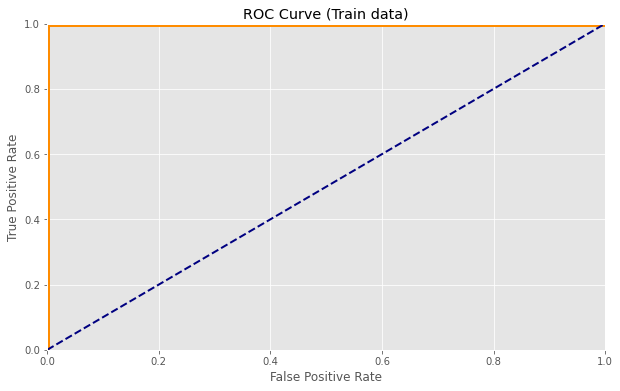

In [30]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, color="darkorange", linewidth=6, label=label)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.axis([0, 1, 0, 1])
    plt.title(label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr, "ROC Curve (Train data)")
# plot_roc_curve(fpr, tpr, "ROC Curve (Test data)")
plt.show()

In [31]:
# Area under the ROC curve
print("Area under the ROC curve: ", roc_auc_score(y_train, y_scores))
# print("Area under the ROC curve: ", roc_auc_score(y_test, y_scores_test))

Area under the ROC curve:  1.0


###### Precision-Recall Curve

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_test)

print("\nPrecisions & Recalls for various threshold values: \n")
print("\nPrecisions: ", precisions)
print("\nRecalls: ", recalls)
print("\nThresholds: ", thresholds)


Precisions & Recalls for various threshold values: 


Precisions:  [1. 1.]

Recalls:  [1. 0.]

Thresholds:  [1.]


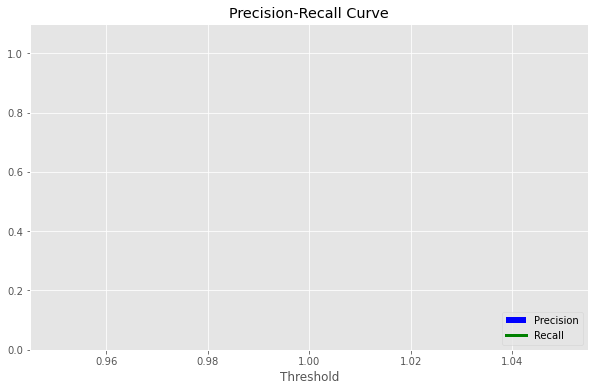


Optimal Threshold:  1.0

Optimal Threshold (approx., second try):  1.0


In [33]:
fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", linewidth=6, label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", linewidth=3, label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# find optimal threshold
threshold_optimal = -1
for i in range(len(precisions)):
#     if(round(precisions[i], 2) == round(recalls[i], 2)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("\nOptimal Threshold: ", threshold_optimal)

# There is no similar threshold for the arrays of precisions & recalls
#  -> approximate by calculating the threshold with the smallest difference between precisions & recall
optimal_threshold = sorted(list(zip(np.abs(precisions - recalls), thresholds)), key=lambda i: i[0], reverse=False)[0][1]

print("\nOptimal Threshold (approx., second try): ", optimal_threshold)

###### After Thresholding

In [34]:
t = threshold_optimal # optimal threshold from precision-recall curve 

y_test_predicted = (knn.predict_proba(X_test_tfidf_vectorized_features)[:, 1] > t).astype(int)

print("\nPerformance Measures Using Optimal Threshold from Precision-Recall Curve: ")
print("Test Accuracy: ", np.mean(y_test == y_test_predicted))

print("\nTest Confusion Matrix: ")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report: ")
print(classification_report(y_test, y_test_predicted, target_names = ['Fake', 'Real']))


Performance Measures Using Optimal Threshold from Precision-Recall Curve: 
Test Accuracy:  0.07868852459016394

Test Confusion Matrix: 
[[ 24   0]
 [281   0]]

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.08      1.00      0.15        24
        Real       0.00      0.00      0.00       281

    accuracy                           0.08       305
   macro avg       0.04      0.50      0.07       305
weighted avg       0.01      0.08      0.01       305



- Q-3) Compare the results from experiment 2 and 3. What changes do you observe. Explain.

**Ans:**

#### **Experiment 4:** 
Based on the precision-recall curve from experiment 3, find a threshold the increases the test recall for the misinformation class, but does not decrease the test precision much for the same class. Using the optimal threshold, compute test accuracy, test confusion matrix, and test classification report.

- Q-4) Compare the results from experiment 3 and 4. What changes do you observed. Explain.

**Ans:**